In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('model.csv')

In [3]:
df.head()

,Unnamed: 0,sim_content,sin_comment,word_count,duplicate_word_ratio,no_of_sentences,length_of_comment,num_of_punctuations,is_period_sequence,stop_word_ratio,post_coment_gap,black_word_count,is_link,is_youtube_link,is_number,is_mail,comment_duplication,classifier_val
0,0,0.372249,0.280355,3.057751,0.083333,3,6.612096,4.0,0,0.000000,8.750086,1.0,1,0,0,0,0.000000,1
1,1,0.354255,0.341604,2.410947,0.000000,1,4.897796,1.0,0,0.000000,15.380144,2.0,0,0,0,0,0.715092,0
2,2,0.487752,0.314966,1.578192,0.000000,1,3.791178,0.0,0,0.000000,14.181022,0.0,0,0,0,0,0.000000,0
3,3,0.468095,0.368193,2.328976,0.000000,1,5.041488,0.0,0,0.090909,13.636652,2.0,0,0,0,0,0.000000,0
4,4,0.366191,0.258061,2.238987,0.000000,1,5.174158,4.0,0,0.000000,13.529500,0.0,1,1,0,0,0.000000,0


In [4]:
df.rename(columns={'Unnamed: 0':'id'},inplace=True)
df.columns

Index(['id', 'sim_content', 'sin_comment', 'word_count',
       'duplicate_word_ratio', 'no_of_sentences', 'length_of_comment',
       'num_of_punctuations', 'is_period_sequence', 'stop_word_ratio',
       'post_coment_gap', 'black_word_count', 'is_link', 'is_youtube_link',
       'is_number', 'is_mail', 'comment_duplication', 'classifier_val'],
      dtype='object')

#### Standardization  is no need for xgboost

In [5]:
dfc = df.copy()

In [6]:
y = dfc['classifier_val']
X = dfc.drop(['classifier_val','id'],axis=1)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Handle imbalnce dataset (here we gonna use oversampling instead of smotec)

In [8]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

os=RandomOverSampler(0.9)
X_train_ns,y_train_ns=os.fit_sample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_ns)))

X_train = X_train_ns
y_train = y_train_ns

The number of classes before fit Counter({0: 1778, 1: 409})
The number of classes after fit Counter({0: 1778, 1: 1600})


C:\Users\Acer\anaconda3\lib\site-packages\imblearn\utils\_validation.py:638: FutureWarning: Pass sampling_strategy=0.9 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning)


#### Hyperparameter Tuninng


In [9]:
from xgboost import XGBClassifier

In [10]:
xgb = XGBClassifier()

In [11]:
xgb.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [13]:
grid = {
    
    'max_depth':range(3,50),
 'min_child_weight':range(1,20),
 'gamma':[i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)],
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

In [14]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True)

In [17]:
from sklearn.model_selection import RandomizedSearchCV
xgb_random = RandomizedSearchCV(estimator=xgb, param_distributions=grid, n_jobs=-1,n_iter = 100, cv=cv, scoring='accuracy',error_score=0,return_train_score=True,verbose=2)

In [18]:
xgb_random.fit(X_train,y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.3min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
                   error_score=0, estimator=XGBClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8,
                                                             0.9],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'max_depth': range(3, 50),
                                        'min_child_weight': range(1, 20),
                                        'reg_alpha': [1e-05, 0.01, 0.1, 1, 100],
                                        'subsample': [0.6, 0.7, 0.8, 0.9]},
                   return_train_score=True, scoring='accuracy', verbose=2)

#### Evaluvate

In [19]:
best_model = xgb_random.best_estimator_

In [20]:
best_model

XGBClassifier(colsample_bytree=0.9, gamma=0.1, max_depth=17, min_child_weight=2,
              reg_alpha=0.01, subsample=0.8)

In [21]:
xgb_random.best_params_

{'subsample': 0.8,
 'reg_alpha': 0.01,
 'min_child_weight': 2,
 'max_depth': 17,
 'gamma': 0.1,
 'colsample_bytree': 0.9}

In [22]:
xgb_random.best_score_

0.9775025020631046

In [23]:
y_pred = best_model.predict(X_test)

In [24]:
err  =(y_pred- y_test)

<AxesSubplot:>

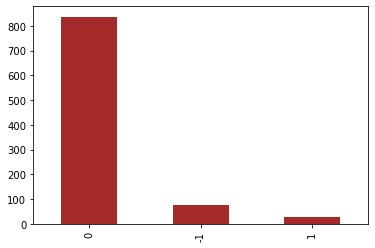

In [26]:
err.value_counts().plot(kind='bar',color='brown')

In [27]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.10767590618336886
MSE: 0.10767590618336886
RMSE: 0.3281400709809286


Text(0, 0.5, 'Feature Importance Score')

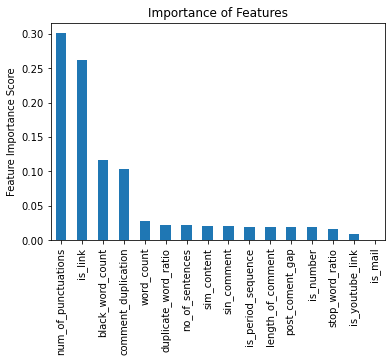

In [28]:
indices=list(X_train)
feat_imp = pd.Series(best_model.feature_importances_, indices).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[735  27]
 [ 74 102]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       762
           1       0.79      0.58      0.67       176

    accuracy                           0.89       938
   macro avg       0.85      0.77      0.80       938
weighted avg       0.89      0.89      0.89       938



In [30]:
print("accuracy is {}".format(best_model.score(X_test, y_test)))

accuracy is 0.8923240938166311


In [31]:
#import pickle
# open a file, where you ant to store the data
#file = open('random_forest_regression_model_v2.pkl', 'wb')
# dump information to that file
#pickle.dump(rf_random, file)

## EXtra Works

In [32]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [33]:
baseline_roc_auc = roc_auc_score(y_test, best_model.predict(X_test))
fprB, tprB, thresholdsB = roc_curve(y_test, best_model.predict_proba(X_test)[:,1])

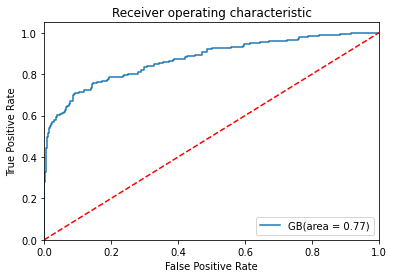

In [34]:
plt.figure()
plt.plot(fprB, tprB, label='GB(area = %0.2f)' % baseline_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()